In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import teetool as tt
import os

/home/will/anaconda3/envs/teetool/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def getFile(fileName):
    """
    downloads file if not yet done so
    """
    
    locale_path = "data/{0}".format(fileName)
    online_path = "https://www.southampton.ac.uk/~wje1n13/camrocsim/{0}".format(fileName)
    
    if not os.path.isfile(locale_path):
        !wget $online_path -O $locale_path

In [3]:
getFile("rocket-A-sim2-north-wind.csv")

In [4]:
# SETTINGS
M = 200 # resampling (reduces points, doesn't interpolate), negative turns off
store_this_case_x = "t2 [-]" # choose dimension!

In [5]:
# read data

df = pd.read_csv("data/rocket-A-sim2-north-wind.csv")

# rename columns
df.rename(columns={'TIME_SECONDS_DOUBLE': 't [s]', 
                   'EASTINGS_METERS_DOUBLE': 'x [m]',
                   'NORTHINGS_METERS_DOUBLE': 'y [m]',
                   'ALTITUDE_METERS_DOUBLE': 'z [m]',
                   'DISTANCE_METERS_DOUBLE': 'd [m]'}, inplace=True)


# "is_event column
temp = np.diff(df["EVENT_INT"])
temp = np.concatenate(([0],temp))
df["is_event"] = (temp == 1)

df_us = df # copy

# normalise x y z GLOBALLY (all trajectories)
these_cells_input = ["x [m]", "y [m]", "z [m]"]
these_cells_output = ["x [-]", "y [-]", "z [-]"]

for (i, cell_input) in enumerate(these_cells_input):
    cell_output = these_cells_output[i]
    df_us.loc[:,cell_output] = (df_us[cell_input] - df_us[cell_input].min()) / ( df_us[cell_input].max() - df_us[cell_input].min() )

# normalise time / distance LOCALLY (per trajectory)
these_cells_input = ["t [s]", "d [m]"]
these_cells_output = ["t [-]", "d [-]"]

for (i, cell_input) in enumerate(these_cells_input):
    cell_output = these_cells_output[i]
    df_col = df_us[cell_input]
    temp = [];
    for i1 in df_us.ID_STR.unique():
        # this trajectory
        df1 = df_col[(df_us["ID_STR"] == i1)]
        temp1 = ( df1 - df1.min() ) / ( df1.max() - df1.min() )
        # concatenate
        temp = np.concatenate((temp, temp1.values), axis=0)
    # store altered dimension
    df_us[cell_output] = temp
    
# find partitions
df_part = pd.DataFrame(columns = ["EVENT_INT","ID_STAGE_STR","DIM","MIN","MAX"])

these_dim = ["t [-]", "d [-]"]

# use mean trajectory as guide
df1 = df_us[df_us["ID_STR"] == 0]

last_max_dic = {}

for this_dim in these_dim:
    last_max_dic[this_dim] = 0
    

for this_stage in df_us["ID_STAGE_STR"].unique():
    # this stage

    for this_event in df_us["EVENT_INT"].unique():
        # this event

        # consider only this segment of events
        df2 = df_us[df_us["EVENT_INT"] == this_event]

        for this_dim in these_dim:
            # this dimension

            # extract this dimension
            df3 = df2[this_dim]

            # extract minimum range of this segment
            event_min = last_max_dic[this_dim]

            # extract maximum range of this segment
            event_max = df3.max()
            
            # update last max
            last_max_dic[this_dim] = event_max

            # calculate different
            #event_diff = event_max - event_min

            # new addition
            df_temp = pd.DataFrame({"EVENT_INT":[this_event],
                                    "DIM":[this_dim],"MIN":[event_min],
                                    "MAX":[event_max],
                                   "ID_STAGE_STR":[this_stage]})

            # append addition
            df_part = df_part.append(df_temp,ignore_index=True)

# normalise time / distance SUPER LOCALLY (per trajectory, per segment)
these_cells_input = ["t [-]", "d [-]"]
these_cells_output = ["t2 [-]", "d2 [-]"]

for (i, this_dim) in enumerate(these_cells_input):
    
    # input / output combination
    cell_output = these_cells_output[i]
    
    # consider this dimension
    #this_dim = df_us[cell_input]
    
    for this_traj in df_us.ID_STR.unique():
        # this trajectory
        #df2 = df1[(df_us["ID_STR"] == this_traj)]
        
        for this_event in df_us.EVENT_INT.unique():
            # single segment/event
            these_rows = ((df_us["ID_STR"] == this_traj) &
                            (df_us["EVENT_INT"] == this_event))
            
            # extract data
            temp_data = df_us.loc[these_rows, this_dim]
                        
            # normalised array (one trajectory, one segment)
            temp_norm = ( temp_data - temp_data.min() ) / ( temp_data.max() - temp_data.min() )
            
            # extract information 
            these_rows2 = ((df_part["DIM"] == this_dim) &
                               (df_part["EVENT_INT"] == this_event))
            
            event_min = df_part.loc[these_rows2, "MIN"].values
            event_max = df_part.loc[these_rows2, "MAX"].values
            
            # modify to fit stretch
            temp_fit = (event_max - event_min) * temp_norm + event_min
            
            # store new data in cell_output
            df_us.loc[these_rows, cell_output] = temp_fit


In [6]:
# flick data into arrays

# number of trajectories
N = df_us.ID_STR.unique().size

cluster_data = []

for (n, id_str) in enumerate(df_us.ID_STR.unique()):
    
    df1 = df_us[df_us["ID_STR"] == id_str]
    
    Yn = np.array([df1["x [m]"].values, df1["y [m]"].values, df1["z [m]"].values]).transpose()
    # yn = np.reshape(Yn, (-1,1), order='F')
    xn = np.array(df1[store_this_case_x].values)
    
    # filter finite values
    mask = np.isfinite(xn)
    Yn = Yn[mask, :]
    xn = xn[mask]
    
    # add tuple to list
    cluster_data.append((xn, Yn))

In [7]:
# temporary store data in pickle
pd.to_pickle(cluster_data,"part2.pickle")

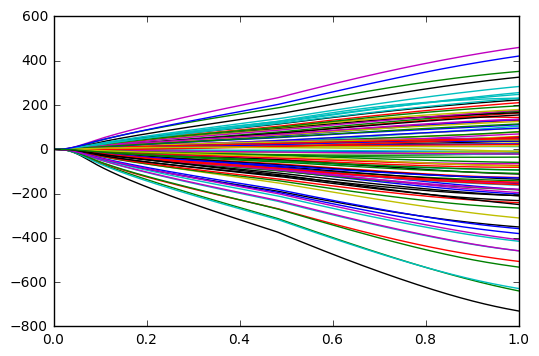

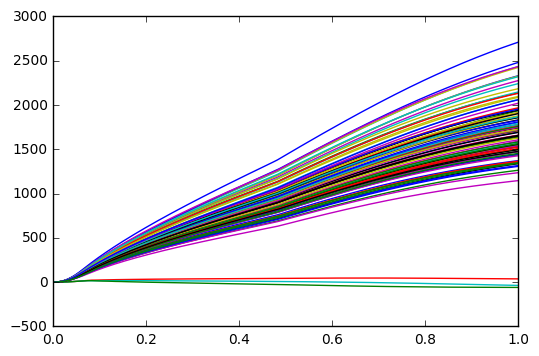

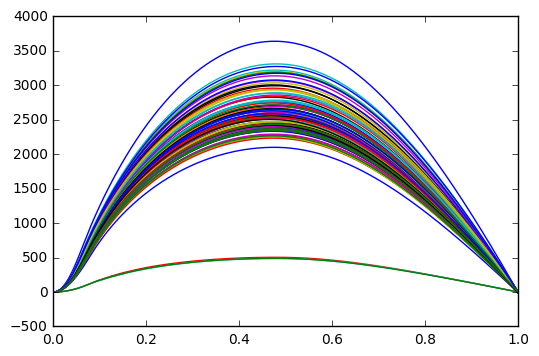

In [8]:
%matplotlib inline

for d in [0, 1, 2]:
    fig = plt.figure()
    ax = fig.gca()
    for (xn, Yn) in cluster_data:
        ax.plot(xn, Yn[:,d])


In [11]:
# settings
#settings = {"model_type":"EM", "ngaus":100, "basis_type":"bernstein", "nbasis":5}
settings = {"model_type":"resampling", "ngaus":100}

# build world
world_name = "Cambridge Rocketry Simulator"

# build world
new_world = tt.World(name=world_name, ndim=3)

# modify default resolution
new_world.setResolution(xstep=10, ystep=10, zstep=10)

new_world.addCluster(cluster_data, "rocket trajectories")

# overview
new_world.overview()

# model
new_world.buildModel(0, settings)
new_world.overview()  # overview

# log
new_world.buildLogProbality(0)
new_world.overview()  # overview

*** overview [Cambridge Rocketry Simulator] ***
0 [rocket trajectories] [-] [-]
*** overview [Cambridge Rocketry Simulator] ***
0 [rocket trajectories] [*] [-]
number of calculations: 1000
..
*** overview [Cambridge Rocketry Simulator] ***
0 [rocket trajectories] [*] [*]


In [12]:
# visuals by mayavi
visual = tt.visual_3d.Visual_3d(new_world)
# visualise trajectories
visual.plotTrajectories([0])
# visualise intersection
visual.plotLogProbability([0])
# visualise outline
visual.plotOutline()
# wait to close
visual.show()